# Load libraries

In [1]:
import h5py
import pandas as pd
import numpy as np
import torch
import polars as pl
import gc # Garbage collector
import math
import matplotlib.pyplot as plt

# And functions from data preparation

# Read the inputs.

In [2]:
signal_df = pl.read_csv('../data/signal_test.csv')
background_df = pl.read_csv('../data/background_test.csv')

In [3]:
# define the features you are interested in
input_features = signal_df.columns
df_signal_filtered = signal_df[input_features]
df_background_filtered = background_df[input_features]

# Prepare targes, features for learning

In [4]:
# Set targets for training
y_signal     = np.ones(len(df_signal_filtered))
y_background = np.zeros(len(df_background_filtered))
print(len(y_signal))
print(len(y_background))

87344
60687


In [5]:
# Combine the dataframes as one big numpy array
input_data = np.concatenate((df_signal_filtered, df_background_filtered), axis=0)
target     = np.concatenate((y_signal, y_background), axis=0)

In [6]:

# split data into train, validation, and test sets (You can also do the shuffle here, if not shuffled before)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_indices, test_indices = next(sss.split(input_data, target))

X_train, y_train = input_data[train_indices], target[train_indices]
X_temp, y_temp = input_data[test_indices], target[test_indices]
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True)

# Choose device for training

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [8]:
# Scale the data to lie between -1 and 1 using sklearn StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [9]:
# As tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

# Define the model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleDNN(nn.Module):
    def __init__(self, N_input_features): # You can add more parameters here, such that the size of all layers can be
        # defined in the constructor
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(SimpleDNN, self).__init__()
        self.linear1 = nn.Linear(N_input_features, N_input_features)
        self.linear2 = nn.Linear(N_input_features, 30)
        self.linear3 = nn.Linear(30, 20)
        self.linear4 = nn.Linear(20, 1)
        self.dropput = nn.Dropout(p=0.1)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # Compute the forward pass.
        # The first layer is self.linear1, then we apply the ReLU activation function
        x1     = F.relu(self.linear1(x))
        x1dp = self.dropput(x1)
        # layer2
        x2     = F.relu(self.linear2(x1dp))
        x2dp = self.dropput(x2)
        #layer 3
        x3     = F.relu(self.linear3(x2dp))
        x3dp   = self.dropput(x3)
        # The final layer is self.linear24 then we apply the sigmoid activation function to get our final output
        y_pred = F.sigmoid(self.linear4(x3dp))
        return y_pred

N_features = len(input_features)
model = SimpleDNN(N_features).to(device)

In [11]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0001)

# Map the padding to valid inputs

In [12]:
X_train_tensor = torch.nan_to_num(X_train_tensor, nan=-2)
X_val_tensor = torch.nan_to_num(X_val_tensor, nan= -2)
X_test_tensor = torch.nan_to_num(X_test_tensor, nan=-2)

# Train

In [13]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor,
                              y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,
                              y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,
                              y_test_tensor)

# Create DataLoader objects for training, validation, and testing in batches
train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True, num_workers=8, persistent_workers=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=5000, shuffle=False, num_workers=8, persistent_workers=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=8)

In [14]:
# Training loop on mini-batches with loss stored for plotting
train_losses = []
val_losses = []
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    # run over batches of data
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs_device = inputs.to(device)
        targets_device = targets.to(device)
        outputs = model(inputs_device)
        loss = criterion(outputs.squeeze(), targets_device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # compute avergae loss over all batches
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs_device = inputs.to(device)
            targets_device = targets.to(device)
            outputs = model(inputs_device)
            loss = criterion(outputs.squeeze(), targets_device)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/600, Train Loss: 0.6743, Val Loss: 0.6666
Epoch 2/600, Train Loss: 0.6659, Val Loss: 0.6602
Epoch 3/600, Train Loss: 0.6597, Val Loss: 0.6515
Epoch 4/600, Train Loss: 0.6493, Val Loss: 0.6327
Epoch 5/600, Train Loss: 0.6253, Val Loss: 0.5944
Epoch 6/600, Train Loss: 0.5842, Val Loss: 0.5340
Epoch 7/600, Train Loss: 0.5372, Val Loss: 0.4930
Epoch 8/600, Train Loss: 0.5055, Val Loss: 0.4697
Epoch 9/600, Train Loss: 0.4870, Val Loss: 0.4554
Epoch 10/600, Train Loss: 0.4800, Val Loss: 0.4521
Epoch 11/600, Train Loss: 0.4719, Val Loss: 0.4531
Epoch 12/600, Train Loss: 0.4614, Val Loss: 0.4393
Epoch 13/600, Train Loss: 0.4540, Val Loss: 0.4335
Epoch 14/600, Train Loss: 0.4506, Val Loss: 0.4317
Epoch 15/600, Train Loss: 0.4457, Val Loss: 0.4265
Epoch 16/600, Train Loss: 0.4408, Val Loss: 0.4227
Epoch 17/600, Train Loss: 0.4379, Val Loss: 0.4215
Epoch 18/600, Train Loss: 0.4345, Val Loss: 0.4162
Epoch 19/600, Train Loss: 0.4309, Val Loss: 0.4152
Epoch 20/600, Train Loss: 0.4277, Val Lo

# Check the loss

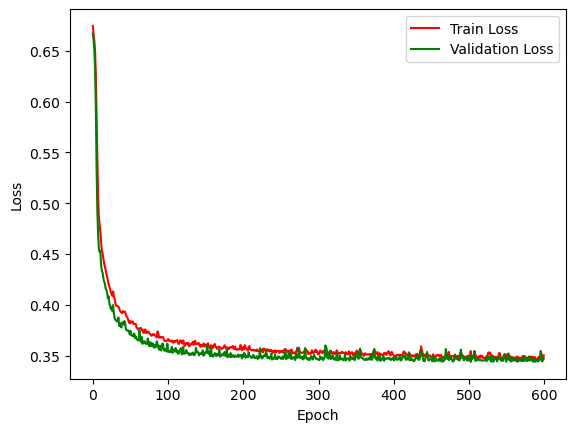

In [15]:
# Plot loss function for training and validation sets
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])

# Save model (if good?)

In [16]:
save_model = False
if save_model:
    torch.save(model.state_dict(), 'model_weights.pth')

# Performance evaluation

In [17]:
# Evaluate the model on the test dataset
# per default  PyTorch will add the predicted values to the computation graph
# Call the detach() method to remove them
load_model = False
if load_model:
    model = SimpleDNN(N_features)
    model.load_state_dict(torch.load('model_weights.pth', weights_only=True))

model.to('cpu')
model.eval()
y_pred = model(X_test_tensor).detach()

In [18]:
# Filter the predicted events for true Signal and true Background
true_signal = y_pred[y_test==1].numpy()
true_bkg = y_pred[y_test==0].numpy()

(0.0, 1.0)

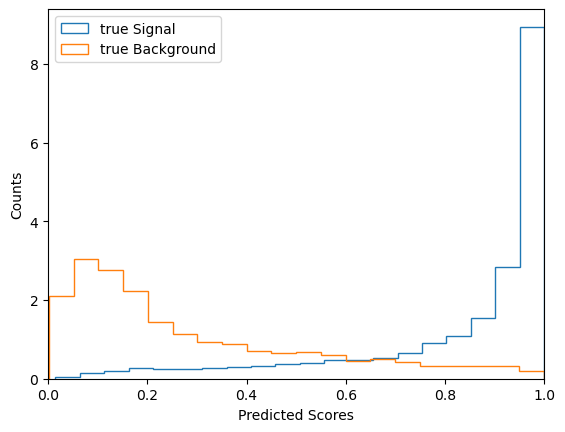

In [20]:
# Plot the predicted scores for both true Signal and true Background events
import matplotlib.pyplot as plt
plt.hist(true_signal, bins=20, histtype='step', label='Signal', density=True)
plt.hist(true_bkg, bins=20, histtype='step', label='Background', density=True)
plt.legend(["true Signal","true Background"])
plt.xlabel("Predicted Scores")
plt.ylabel("Counts")
plt.xlim((0.0,1.0))

In [21]:
# sklearn.metrics require exact value matches, so we need to round to 0 or 1
final_prediction_score =y_pred.numpy()
final_prediction = np.round(final_prediction_score)

In [22]:
# Compute the accuracy_score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, final_prediction)
print(accuracy)

0.8457173736827884


In [23]:
# Caclulate some other metrics that are suitable for a classification
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_test, final_prediction, average='weighted')
recall = recall_score(y_test, final_prediction, average='weighted')
f1 = f1_score(y_test, final_prediction, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.8451852854449788
Recall: 0.8457173736827884
F1 Score: 0.8452147422164749


In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,final_prediction_score)

np.float64(0.9255338443000707)

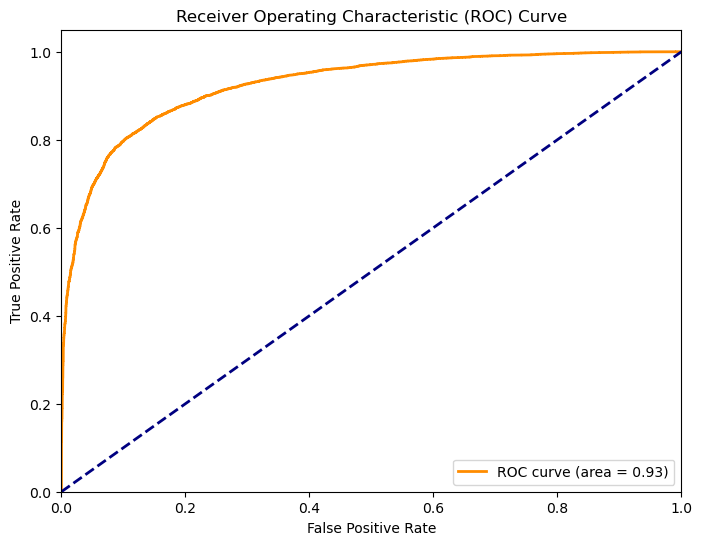

In [25]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, final_prediction_score)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [40]:
# Compute feature importance of 26 input features to DNN
import numpy as np

def accuracy_score(y,x):
    a = y_val_tensor.detach().numpy()
    b = x[:,0]

    return sum((a - b)**2)/len(a)

def permutation_importance(model, X_val_tensor, y_val):

    detach_to_binary = lambda x: np.round(model(x).detach().numpy(),decimals=6)

    baseline_score = accuracy_score(y_val, detach_to_binary(X_val_tensor))  # For a classification task
    importances = []

    for feature_idx in range(X_val_tensor.shape[1]):
        # Shuffle the values of the current feature
        X_val_shuffled = X_val_tensor.clone()
        X_val_shuffled[:, feature_idx] = X_val_shuffled[:, feature_idx][torch.randperm(X_val.shape[0])]

        # Recalculate the performance
        score_shuffled = accuracy_score(y_val, detach_to_binary(X_val_shuffled))
        print(score_shuffled)

        # The difference in performance is the importance of this feature
        importances.append(100*(baseline_score - score_shuffled)/baseline_score)

    return np.array(importances)

# Usage example
importances = permutation_importance(model, X_val_tensor, y_val_tensor)

0.12341836
0.11466755
0.10929045
0.109975465
0.1095993
0.13277522
0.12748979
0.13799876
0.12461371
0.11315077
0.1135657
0.10969228
0.13166253
0.12141448
0.10965773
0.10952119
0.1089748
0.10948797
0.109509826
0.12039351
0.11256993
0.18318109
0.190923
0.11444812
0.11301218
0.11278557
0.1334174
0.114652194
0.112043925
0.11159202
0.1474646
0.114230305
0.110098846
0.15313047
0.13135129
0.1090579
0.1090579
0.1168371
0.1184307
0.11397349
0.1328417
0.11825215
0.1090579
0.1090579
0.11046283
0.11406644
0.110741846
0.12800957
0.13806453


In [41]:
idx = np.argsort(np.asarray(importances))

In [42]:
sorted_features_descending = np.array(signal_df.columns)[idx]

for i in range(len(sorted_features_descending)):
    print(f"Feature: {sorted_features_descending[i]}, Importance: {importances[idx[i]]:.4f}")

Feature: pt1, Importance: -75.0657
Feature: pt0, Importance: -67.9668
Feature: btag5, Importance: -40.4121
Feature: btag2, Importance: -35.2168
Feature: type6, Importance: -26.5975
Feature: eta0, Importance: -26.5371
Feature: pt5, Importance: -22.3363
Feature: charge5, Importance: -21.8084
Feature: e5, Importance: -21.7474
Feature: eta5, Importance: -20.7272
Feature: btag6, Importance: -20.4418
Feature: type5, Importance: -17.3776
Feature: e6, Importance: -16.9010
Feature: eta1, Importance: -14.2638
Feature: e0, Importance: -13.1677
Feature: eta6, Importance: -11.3303
Feature: phi5, Importance: -10.3941
Feature: charge3, Importance: -8.5943
Feature: charge6, Importance: -8.4306
Feature: charge2, Importance: -7.1331
Feature: e1, Importance: -5.1437
Feature: pt6, Importance: -5.1297
Feature: pt2, Importance: -4.9425
Feature: btag3, Importance: -4.7428
Feature: type3, Importance: -4.5925
Feature: charge4, Importance: -4.5073
Feature: eta3, Importance: -4.1334
Feature: eta2, Importance: -3

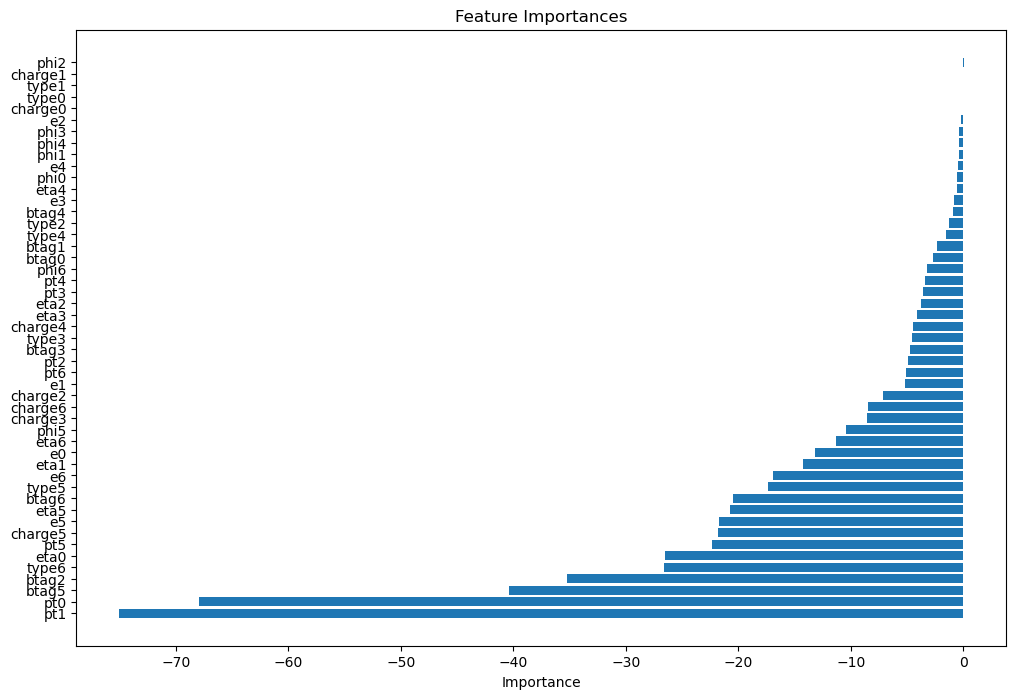

In [43]:
# Plot feature importances
import matplotlib.pyplot as plt
importances = importances[idx]
plt.figure(figsize=(12, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), sorted_features_descending)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()